# Quick demo of Accumulator and DDM classes and OOP usage
Steven Jerjian
Jan 2026

This is a quick demo to show the basic functionality of the low-level accumulator class, and the Self-Motion DDM class. The latter uses the Accumulator class to fit 2-D anti-correlated accumulators to the different conditions in a provided dataframe of trials with different headings, modalities, and visual coherences.

Hovering over the class calls or methods should show some docstring documentation, although this needs further cleanup to make sure it is up-to-date and fully explained.


EXTRA NOTES:
- there is a bit of a hack to scale kmult up in the predict method of SelfMotionDDM to make drifts be in the right order of magnitude for reasonable outputs from (because it's helpful for pybads if all the fitting parameters are in the same ballpark), and this scaling differs depending on whether stimuli are scaled by acceleration/velocity profiles or not. Probably need to make this more robust, perhaps have it be dynamically adjusted rather than hard-coded, and/or consider whether some fitting parameters need to be on a log scale.
- behavior.descriptive has become outdated/broken - need to update to use simple plotting functions e.g. psychometric/chronometric curves for actual and predicted dataframes of trial responses
- there are still likely to be some bugs or extraneous issues that require troubleshooting as and when they are noticed

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from behavior.Accumulator import Accumulator

In [59]:
# Initialize grid vectors for diffusion particle
grid_vec = np.arange(-3, 0, 0.05)  # -3 to 0, steps of 0.01
time_vec = np.arange(0, 2, 0.01)   # 0 to 2s, steps of 50ms

/Users/stevenjerjian/FLprojects/pyDots3DMP/behavior/moi.py:162: RuntimeWarning: divide by zero encountered in log
  logdets = np.sum(np.log(vals), axis=1)
/Users/stevenjerjian/FLprojects/pyDots3DMP/behavior/moi.py:165: RuntimeWarning: divide by zero encountered in divide
  valsinvs = 1./vals
/Users/stevenjerjian/FLprojects/pyDots3DMP/behavior/moi.py:168: RuntimeWarning: invalid value encountered in multiply
  Us = vecs * np.sqrt(valsinvs)[:, None]
/Users/stevenjerjian/FLprojects/pyDots3DMP/behavior/Accumulator.py:245: UserWarning: Adding colorbar to a different Figure <Figure size 500x600 with 3 Axes> than <Figure size 400x500 with 2 Axes> which fig.colorbar is called on.
  cbar = fig_cdf.colorbar(contour, ax=axp[0])
/Users/stevenjerjian/FLprojects/pyDots3DMP/behavior/Accumulator.py:246: UserWarning: Adding colorbar to a different Figure <Figure size 500x600 with 4 Axes> than <Figure size 400x500 with 2 Axes> which fig.colorbar is called on.
  cbar = fig_cdf.colorbar(contour, ax=axp[1]

(<Figure size 400x500 with 2 Axes>, <Figure size 500x600 with 4 Axes>)

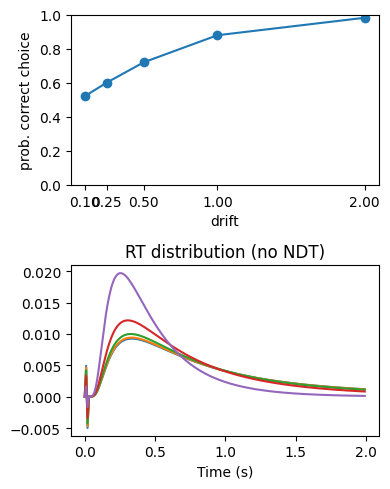

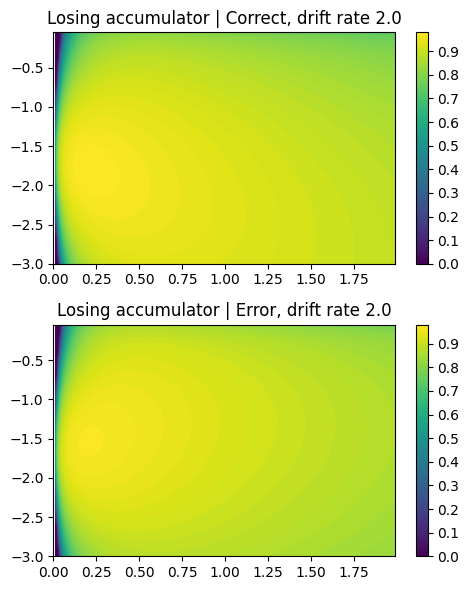

In [60]:
# demonstrate use of single Accumulator object

drifts = [0.1, 0.25, 0.5, 1., 2.]
accum = Accumulator(
    grid_vec=grid_vec,
    tvec=time_vec,
    bound=1,
)
accum.apply_drifts(drifts, labels=drifts) # this "applies" the drifts in [drifts] by creating [tvecx2] anti-correlated accumulators
accum.compute_distrs(return_pdf=True) # this computes the cdf (for choice/RT) and pdf (for wager) using method of images
accum.plot()

For the actual 3DMP task modelling, we use a higher-level wrapper called SelfMotionDDM for fitting/predicting responses using multiple accumulators - one per condition.

We defined some initial parameters

In [61]:
# NOTE on kmult:
# three-element list --> independent sensitivites for ves, low coh vis and high coh vis
# two-element list --> independent sensitivites for ves and vis. low coh and high coh proportional based on values
# one-element --> low coh and high coh proportional based on values, mean(low, high) = ves
#
# all other init_params values are lists, but can be:
# single element - same value for all modalities
# three elements - independent value per modality    

init_params = {
    'kmult': [1, 1],        # ves, vis sensitivites
    'bound': [1, 1, 1],         # ves, vis, comb bounds
    'non_dec_time': [0.3],      # non-decision time (secs)
    'wager_thr': [0.5, 0.5, 0.5],     # log odds threshold for high bets
    'wager_alpha': [0.05],      # base rate of high bets
}


In [ ]:
from behavior.selfmotionddm import SelfMotionDDM
from behavior.utils import dots3DMP_create_trial_list
from behavior.descriptive import plot_behavior_hdg, gauss_fit_hdg_group

# generate list of unique conditions
X = dots3DMP_create_trial_list(
    hdgs=[-12, -6, -3, 0, 3, 6, 12],
    mods=[1, 2, 3],
    cohs=[0.3, 0.7],
    deltas=[0],
    nreps=1
)

# initialize DDM object (just for inference/prediction)
ddm = SelfMotionDDM(
    grid_vec=grid_vec,
    tvec=time_vec,
    **init_params, 
    stim_scaling=True,      # scale ves/vis according to acc/vel signals? can also pass in a 2-length tuple of arrays
    return_wager=True       # whether to compute pdfs and log odds maps, and return wagers
    )

## Predictions

the `predict` method of `SelfMotionDDM` makes a prediction given the current parameters
It returns two "prediction" results as a tuple

the first one contains direct model CDF/PDF inferred choice/wager probabilities and RT likelihoods 
- this is used by the `.fit` method on each iteration of the optimization to calculate NLLs
the second (sample_preds) uses the same set of parameters but instead samples from the predicted model distributions
`n_samples` times (using binomial distribution for choice/wager, and just sampling from predicted RT distribution for RT) to generate results 'as-if' a real subject. There are two effective ways to use this latter output for testing/after optimization.
    - if `n_samples > 1`, then input data can just be the unique conditions, and the output will already look like the average choice, wager, RT per unique condition (but without errors for now)
    - if `n_samples == 1`, then input data should probably be all trials, and the output will look like the raw data i.e. one row per trial, with choice and PDW as binary 0/1. Then mean/SE calculations can be done the same way they are done for real subject data.
    - (if `n_samples == 0`, this second output will be `None`)

NOTE: this sampling method is distinct from actual simulation of DVs per trial (this one is a work in progress still)
the `Accumulator.dv` method can generate sample DVs for a single accumulator object but this is not yet functionally
wrapped by the SelfMotionDDM to generate DVs for every requested trial type/condition (is this needed?)) In the end, actual DV sampling should produce an (unbiased) approximation of the direct model probability sampling methods...

In [64]:
_, sample_preds = ddm.predict(X, n_samples=100, cache_accumulators=False)
pred_final = pd.concat((X, sample_preds), axis=1)
pred_final.head(20)

,modality,coherence,delta,heading,choice,PDW,RT
0,3.0,0.3,0.0,3.0,0.55,0.47,1.0106
1,2.0,0.7,0.0,3.0,0.63,0.00,0.9190
2,2.0,0.3,0.0,-6.0,0.44,0.00,1.0109
3,3.0,0.7,0.0,0.0,0.48,0.38,1.0414
4,2.0,0.3,0.0,3.0,0.57,0.00,0.9739
5,1.0,0.3,0.0,-12.0,0.23,0.35,0.9432
6,3.0,0.3,0.0,-6.0,0.40,0.50,0.9909
7,3.0,0.3,0.0,12.0,0.68,0.52,0.9825
8,3.0,0.7,0.0,-3.0,0.45,0.53,0.9655
9,2.0,0.7,0.0,-3.0,0.48,0.00,1.0013
